Here we do a symlar diagonalization analysis that we did before but using a **non-hermitian hamiltonian**. We do
this to **add dissipation** to our system and try to inder a coherence length from it, in the style of the paper https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.L042031 

**Remember to renormalize the Hamiltonian again**

**Avoid the qubit site when plugging gamma**

**The broadening shhould be smaller than the energy gaps otherwise we dont resolve anything.**


In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
# from scipy.fft import fft, ifft, fftfreq
from tqdm import tqdm


#from scipy.integrate import simpson
# from scipy.interpolate import UnivariateSpline

import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/perturbative/"
data_route = "../data/sims/L=21/"


# Functions

In [3]:
def create_hamiltonians(L, T, Bond, Gamma):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # Gamma = dissipation
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L)) + 0j
    # fill the diagonal with dissipation
    d_indices= kth_diag_indices(H_matrix,0)
    H_matrix[d_indices] = -1j*Gamma
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T 
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco

def get_spectral(Energies, Op = 10**(-5)):
    # calculates the spectral function of th hamiltonian Ham with infinithesimal Op for
    # regularization
    E_arr = np.linspace(min(Energies.real), max(Energies.real), 9000).real
    
    G_list = [] 
    for i in range(0,len(E_arr)):
        # I put the Op above purely for regularizing the result
        Gn = np.sum(1/(E_arr[i] - Energies + 1j*Op))
        G_list.append(Gn)
    # the boundaries frow way too fast because of the delta so we take them out
    
    return E_arr[1:-1] , -2*np.imag(G_list[1:-1])

# Diagonalizing

In [4]:
Omega_list = [0.1, 0.5, 0.9]
J_prime = 1

L_qpc_list = [20,40,80] # qpc length
t_list = [0.02, 0.04, 0.07, 0.1,0.3] # rabi oscillation
gamma_list = [0.001, 0.01, 0.03, 0.06, 0.1]  # add dissipation

ll_qpc = 80
print("perturbative threshold for t")
print(np.pi/(ll_qpc+1))
print("coherence threshlod for gamma")
print(1/ll_qpc)

perturbative threshold for t
0.038785094488762877
coherence threshlod for gamma
0.0125


In [5]:
# create all parameter combinations
comb_array = np.array( np.meshgrid(L_qpc_list,t_list, gamma_list,Omega_list)).T.reshape(-1, 4) 

np.shape(comb_array)

(225, 4)

In [6]:
# for the dataset
data_dict = {"L_qpc" : [],"t":[],"gamma":[], "Omega" : [], "free_energies": [], "free_spectral" : [], "int_energies" : [], 
             "int_energies_m" : [], "int_energies_p" : [], "int_spectral" : [], "gamma_energies" : [], 
             "gamma_energies_p" : [],"gamma_energies_m" : [], "gamma_spectral" : [] , "E_range" : []}

for simulation_index in tqdm(range(0,np.shape(comb_array)[0]), desc="Iterating Parameters"):
    parameter_array = comb_array[simulation_index,:]
    L_qpc = int(parameter_array[0])
    t = float(parameter_array[1])
    gamma = float(parameter_array[2])
    Omega = float(parameter_array[3])
    
    L = L_qpc + 2
    bond_index =  int(L_qpc/2)
    J = np.ones(L_qpc) # QPC hopping
    J[bond_index] = J_prime  

    # build the projection opeartor to the qubit-symmetric sector of the hilbert space
    Id_qpc = np.eye(L_qpc)
    plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
    p_ketbra = np.outer(plusket,plusket)
    Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product
    
    H_dissipative, _ = create_hamiltonians(L_qpc, t, bond_index, gamma)
    
    # Matrix withour dissipation
    H_interact, Hdeco = create_hamiltonians(L_qpc, t, bond_index, 0)
    
    # Calculate the energies and eigenvectors
    energies_gamma, vecs_gamma = np.linalg.eig(H_dissipative)
    vecs_gamma = vecs_gamma/ np.linalg.norm(vecs_gamma, axis=0)
    
    energies_int, vecs_int = np.linalg.eig(H_interact)
    vecs_int = vecs_int/ np.linalg.norm(vecs_int, axis=0)
    
    energies_free, vecs_free = np.linalg.eig(Hdeco)
    vecs_free = vecs_free/ np.linalg.norm(vecs_free, axis=0)
    
    # Sort into bands ---------------------------------------------------
    
    # sort the free evectros into bands according to their projection
    mindices, pindices = sort_by_projection(energies_free,vecs_free, Psym)
    
    # minus band
    free_energies_m = energies_free[mindices]
    free_states_m = vecs_free[:,mindices]
    # sort by magnitude
    free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)
    
    # plus band
    free_energies_p = energies_free[pindices]
    free_states_p = vecs_free[:,pindices]
    # sort by magnitude
    free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)
    
    
    # sort by their overlaps with the free, nondissipative case
    sorted_indices, over_matrix = sort_by_overlap_matrix(energies_int, vecs_free,vecs_int)
    sorted_e = energies_int[sorted_indices]
    sorted_vecs = vecs_int[:,sorted_indices]
    
    int_energies_m = sorted_e[mindices]
    int_states_m = sorted_vecs[:,mindices]
    int_energies_m, int_states_m = mag_sort(int_energies_m, int_states_m)
    
    int_energies_p = sorted_e[pindices]
    int_states_p = sorted_vecs[:,pindices]
    int_energies_p, int_states_p = mag_sort(int_energies_p, int_states_p)
    
    # sort by their overlaps with the free, nondissipative case
    sorted_indices, over_matrix = sort_by_overlap_matrix(energies_gamma, vecs_free,vecs_gamma)
    sorted_e = energies_gamma[sorted_indices]
    sorted_vecs = vecs_gamma[:,sorted_indices]
    gamma_energies_m = sorted_e[mindices]
    gamma_states_m = sorted_vecs[:,mindices]
    gamma_energies_m, int_states_m = mag_sort(gamma_energies_m, gamma_states_m)
    
    gamma_energies_p = sorted_e[pindices]
    gamma_states_p = sorted_vecs[:,pindices]
    gamma_energies_p, gamma_states_p = mag_sort(gamma_energies_p, gamma_states_p)
    
    e_arr, spectral_free = get_spectral( energies_free)
    _, spectral_int = get_spectral(energies_int)
    _, spectral_gamma = get_spectral(energies_gamma)

    data_dict["t"].append(t)
    data_dict["gamma"].append(gamma)
    data_dict["L_qpc"].append(L_qpc)
    data_dict["Omega"].append(Omega)

    data_dict["free_energies"].append(energies_free)
    data_dict["free_spectral"].append(spectral_free)
    data_dict["int_energies"].append(energies_int)
    data_dict["int_energies_p"].append(int_energies_p)
    data_dict["int_energies_m"].append(int_energies_m)
    data_dict["int_spectral"].append(spectral_int)
    data_dict["gamma_energies"].append(energies_gamma)
    data_dict["gamma_energies_p"].append(gamma_energies_p)
    data_dict["gamma_energies_m"].append(gamma_energies_m)
    data_dict["gamma_spectral"].append(spectral_gamma)
    data_dict["E_range"].append(e_arr)

data_df = pd.DataFrame.from_dict(data_dict)


Iterating Parameters: 100%|█████████████████| 225/225 [00:52<00:00,  4.33it/s]


In [7]:

lengths = {key: len(value) for key, value in data_dict.items()}

lengths

{'L_qpc': 225,
 't': 225,
 'gamma': 225,
 'Omega': 225,
 'free_energies': 225,
 'free_spectral': 225,
 'int_energies': 225,
 'int_energies_m': 225,
 'int_energies_p': 225,
 'int_spectral': 225,
 'gamma_energies': 225,
 'gamma_energies_p': 225,
 'gamma_energies_m': 225,
 'gamma_spectral': 225,
 'E_range': 225}

# Broadening of the DOS

for each energy band

In [8]:

print(data_df["t"].unique())
print(data_df["gamma"].unique())
print(data_df["Omega"].unique())


data_df.head()

[0.02 0.04 0.07 0.1  0.3 ]
[0.001 0.01  0.03  0.06  0.1  ]
[0.1 0.5 0.9]


,L_qpc,t,gamma,Omega,free_energies,free_spectral,int_energies,int_energies_m,int_energies_p,int_spectral,gamma_energies,gamma_energies_p,gamma_energies_m,gamma_spectral,E_range
0,20,0.02,0.001,0.1,"[(-1.997661652450255+0j), (-1.9576616524502557...","[101.43408693070481, 25.38422819402984, 11.294...","[(-1.9912580656156982+0j), (-1.948832751268776...","[(-1.9912580656156982+0j), (-1.930248729972266...","[(-1.9488327512687762+0j), (-1.890567331544827...","[102.0867151945782, 25.547222547838604, 11.367...","[(-1.9912580656156973-0.0010000000000000024j),...","[(-1.9488327512687764-0.0009999999999999998j),...","[(-1.9912580656156973-0.0010000000000000024j),...","[1663.3271833238891, 1122.1525888463304, 728.0...","[-1.9972176783081392, -1.9967737041660234, -1...."
1,20,0.04,0.001,0.1,"[(-2.017661652450261+0j), (-1.9511456115722816...","[99.42390741779768, 24.873069295052574, 11.061...","[(-2.0104738792410406+0j), (-1.950890976961961...","[(-2.0104738792410406+0j), (-1.950890976961961...","[(-1.9290856632953746+0j), (-1.870697200933706...","[100.13679602201012, 25.05229903181416, 11.141...","[(-2.0104738792410406-0.0009999999999999987j),...","[(-1.9290856632953746-0.0010000000000000015j),...","[(-2.0104738792410406-0.0009999999999999987j),...","[1657.2307643760141, 1111.851125576431, 718.26...","[-2.0172132333698185, -2.016764814289376, -2.0..."
2,20,0.07,0.001,0.1,"[(2.0476616524502598-0j), (1.9811456115722839+...","[96.53089966852278, 24.14718930538756, 10.7371...","[(-2.0400799247472383+0j), (-1.980655382305479...","[(-2.0400799247472383+0j), (-1.980655382305479...","[(-1.900674424531147+0j), (-1.84024026374497+0...","[97.2505389387812, 24.328169976292756, 10.8182...","[(-2.0400799247472383-0.0009999999999999998j),...","[(-1.900674424531147-0.001000000000000002j), (...","[(-2.0400799247472383-0.0009999999999999998j),...","[1648.9579973851003, 1097.2951704507655, 704.6...","[-2.0472065659623224, -2.0467514794743904, -2...."
3,20,0.10,0.001,0.1,"[(2.0776616524502547-0j), (2.0111456115722754+...","[93.76405355076264, 23.454374550448303, 10.428...","[(-2.0698986872226337+0j), (-2.010612668658095...","[(-2.0698986872226337+0j), (-2.010612668658095...","[(-1.8673399385135705+0j), (-1.810472736040897...","[94.46953048653337, 23.631820844117776, 10.508...","[(-2.0698986872226346-0.0009999999999999974j),...","[(-1.8673399385135705-0.0009999999999999998j),...","[(-2.0698986872226346-0.0009999999999999974j),...","[1640.7785155672243, 1082.9923410962454, 691.4...","[-2.077199898554835, -2.076738144659413, -2.07..."
4,20,0.30,0.001,0.1,"[(-2.277661652450257+0j), (-2.211145611572284+...","[78.02667949202952, 19.516832295074803, 8.6779...","[(-2.2695391745120443+0j), (-2.210555788350036...","[(-2.2695391745120443+0j), (-2.210555788350036...","[(-1.6689871798866063+0j), (-1.610518744404991...","[78.58719773894406, 19.658034700855005, 8.7415...","[(-2.2695391745120443-0.000999999999999998j), ...","[(-1.6689871798866063-0.0010000000000000009j),...","[(-2.2695391745120443-0.000999999999999998j), ...","[1585.6321954026637, 992.0092463322453, 611.03...","[-2.2771554491715706, -2.2766492458928838, -2...."


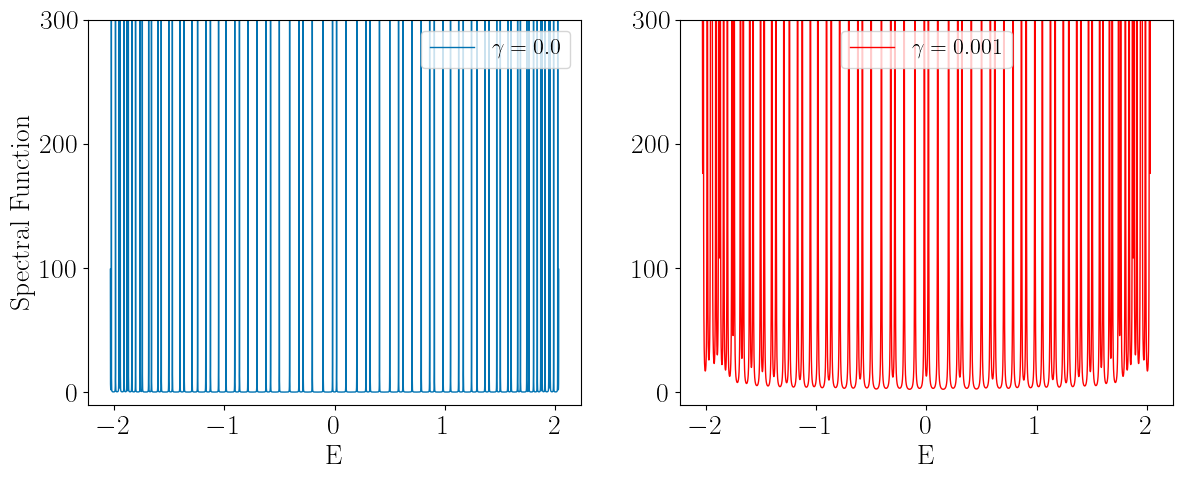

In [9]:
# comparing with non dissipative case
cond = (data_df["t"]==0.04) & (data_df["gamma"]==0.001) & (data_df["L_qpc"]==40) & (data_df["Omega"]==0.5)

E_range = data_df[cond]["E_range"].values[0]
gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
int_spectral = data_df[cond]["int_spectral"].values[0]


fig, ax = plt.subplots(1,2, figsize=(2*bwidth, bheight))
ax[0].plot(E_range, int_spectral , linewidth = 1,  label = r"$\gamma=0.0$" )
ax[1].plot(E_range,gamma_spectral, c="red", linewidth = 1,
           label = r"$\gamma={}$".format(0.001 ))

ax[0].set_xlabel("E")
ax[0].set_ylabel("Spectral Function")
ax[0].set_ylim(-10,300)
ax[0].legend()

ax[1].set_xlabel("E")
ax[1].set_ylim(-10,300)
ax[1].legend()



Varied Size

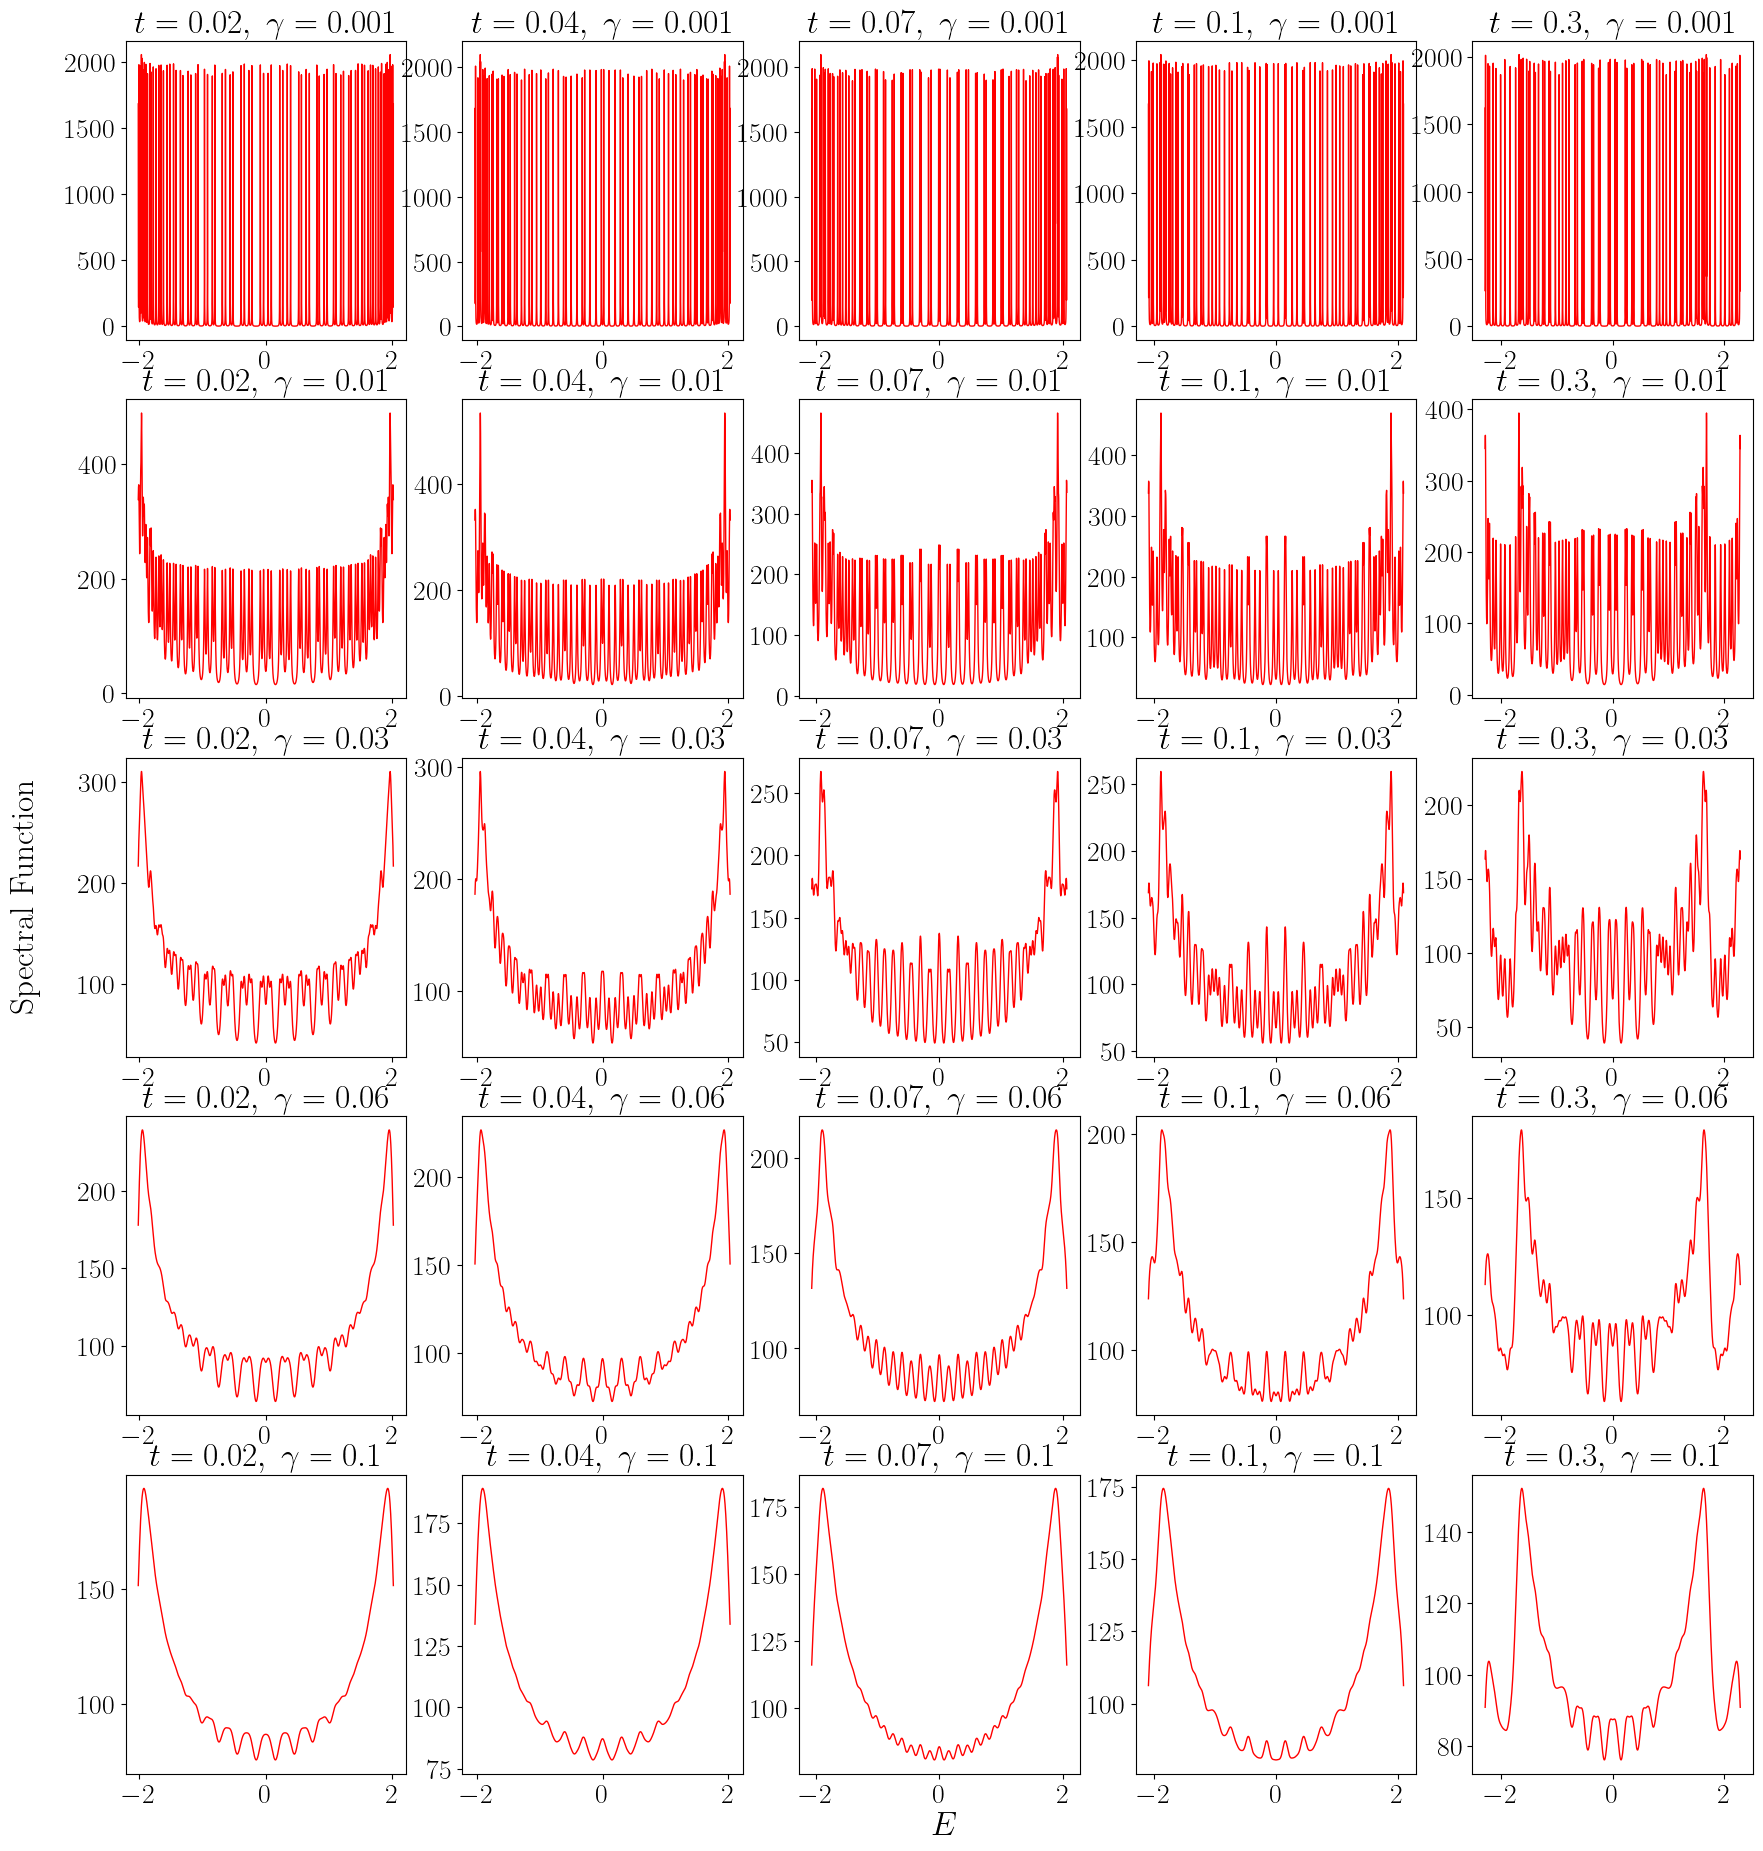

In [10]:
nrows = data_df["gamma"].nunique()
ncols = data_df["t"].nunique()

t_vals = data_df["t"].unique()
gamma_vals = data_df["gamma"].unique()

fig, ax = plt.subplots(nrows,ncols, figsize=(3*bwidth, 4.5*bheight))

for row_ in range(0,nrows):
    for col_ in range(0,ncols): 
        cond = (data_df["t"]==t_vals[col_]) & (data_df["gamma"]==gamma_vals[row_]) & (data_df["L_qpc"]==40) & (data_df["Omega"]==0.5)
        E_range = data_df[cond]["E_range"].values[0]
        gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
                
        ax[row_, col_].plot(E_range, gamma_spectral, c="red", linewidth = 1)
        ax[row_, col_].set_title(r"$t = {},  \; \gamma = {}$".format(t_vals[col_], gamma_vals[row_]))

fig.supylabel("Spectral Function", x=0.07)
fig.supxlabel(r"$E$",x=0.515,y=0.08)

plt.savefig(fig_route+"spectral_broadening_Lqpc={}_Omega={}.pdf".format(40,0.5),bbox_inches='tight')

Varied Rabi 

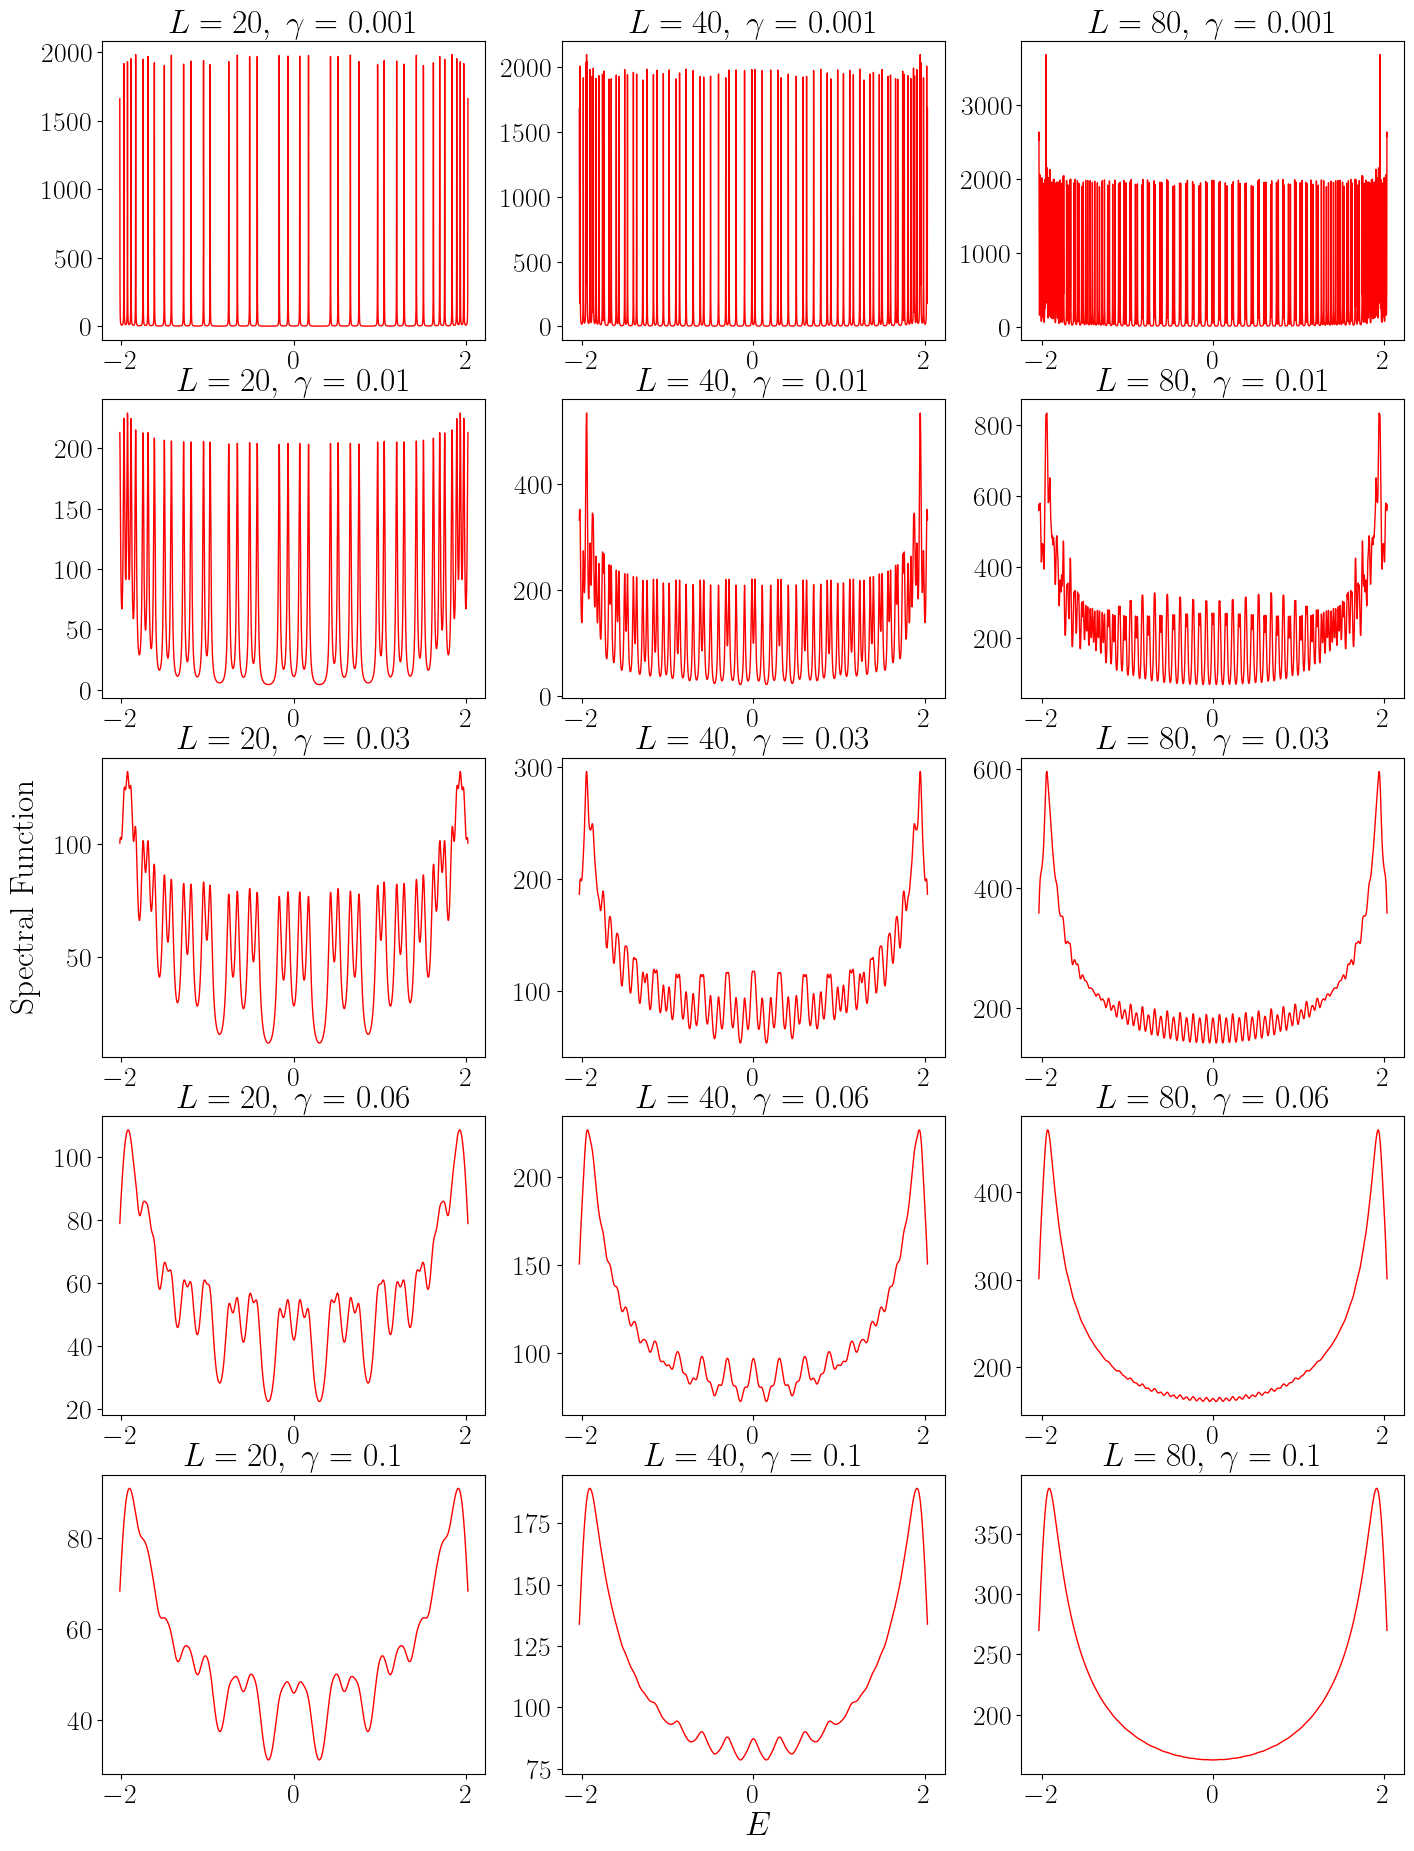

In [11]:
nrows = data_df["gamma"].nunique()
ncols = data_df["L_qpc"].nunique()

L_vals = data_df["L_qpc"].unique()
gamma_vals = data_df["gamma"].unique()

fig, ax = plt.subplots(nrows,ncols, figsize=(2.4*bwidth, 4.5*bheight))

for row_ in range(0,nrows):
    for col_ in range(0,ncols): 
        cond = (data_df["t"]==0.04) & (data_df["gamma"]==gamma_vals[row_]) & (data_df["L_qpc"]==L_vals[col_]) & (data_df["Omega"]==0.5)
        E_range = data_df[cond]["E_range"].values[0]
        gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
                
        ax[row_, col_].plot(E_range, gamma_spectral, c="red", linewidth = 1)
        ax[row_, col_].set_title(r"$L = {},  \; \gamma = {}$".format(L_vals[col_], gamma_vals[row_]))

fig.supylabel("Spectral Function", x=0.07)
fig.supxlabel(r"$E$",x=0.515,y=0.08)

plt.savefig(fig_route+"spectral_broadening_t={}_Omega={}.pdf".format(0.06,0.5),bbox_inches='tight')

Varied Omega

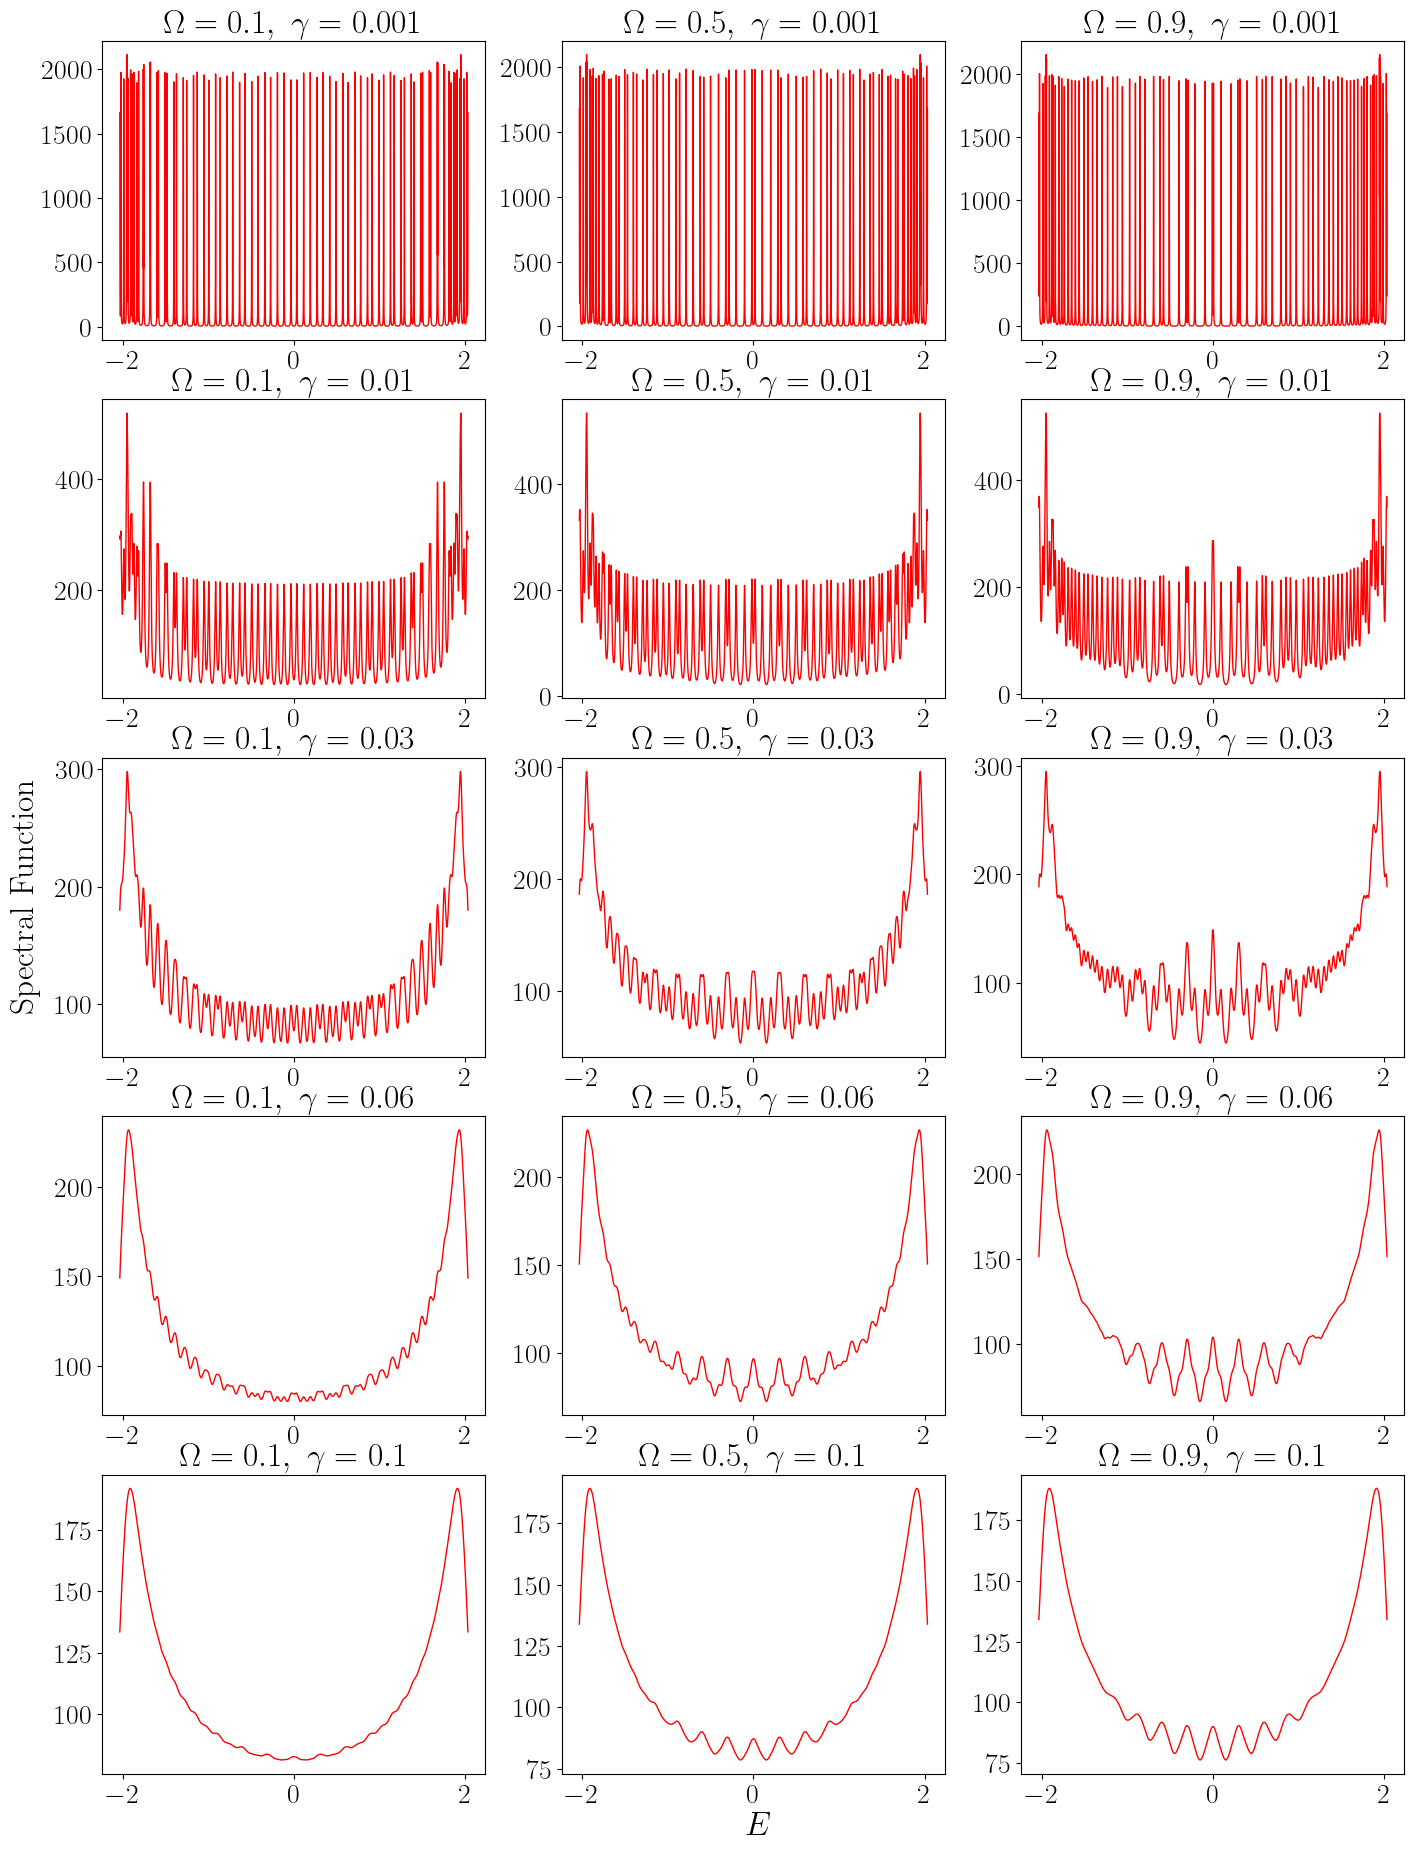

In [12]:
nrows = data_df["gamma"].nunique()
ncols = data_df["Omega"].nunique()

Om_vals = data_df["Omega"].unique()
gamma_vals = data_df["gamma"].unique()
t_ = 0.04
fig, ax = plt.subplots(nrows,ncols, figsize=(2.4*bwidth, 4.5*bheight))

for row_ in range(0,nrows):
    for col_ in range(0,ncols): 
        cond = (data_df["t"]==t_) & (data_df["gamma"]==gamma_vals[row_]) & (data_df["L_qpc"]==40) & (data_df["Omega"]==Om_vals[col_])
        E_range = data_df[cond]["E_range"].values[0]
        gamma_spectral = data_df[cond]["gamma_spectral"].values[0]
                
        ax[row_, col_].plot(E_range, gamma_spectral, c="red", linewidth = 1)
        ax[row_, col_].set_title(r"$\Omega = {},  \; \gamma = {}$".format(Om_vals[col_], gamma_vals[row_]))

fig.supylabel("Spectral Function", x=0.07)
fig.supxlabel(r"$E$",x=0.515,y=0.08)

plt.savefig(fig_route+"spectral_broadening_t={}_Omega={}.pdf".format(0.06,0.5),bbox_inches='tight')

Energy differences

In [13]:
print(gamma_vals)
print(t_vals)
print(L_vals)
np.sort([1,4,5,2])


[0.001 0.01  0.03  0.06  0.1  ]
[0.02 0.04 0.07 0.1  0.3 ]
[20 40 80]


array([1, 2, 4, 5])

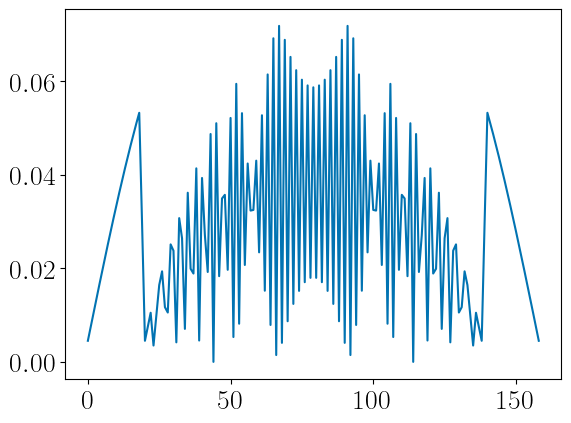

In [26]:
k_single_band


DeltaE0 =  np.diff(E0)
plt.plot(DeltaE0)

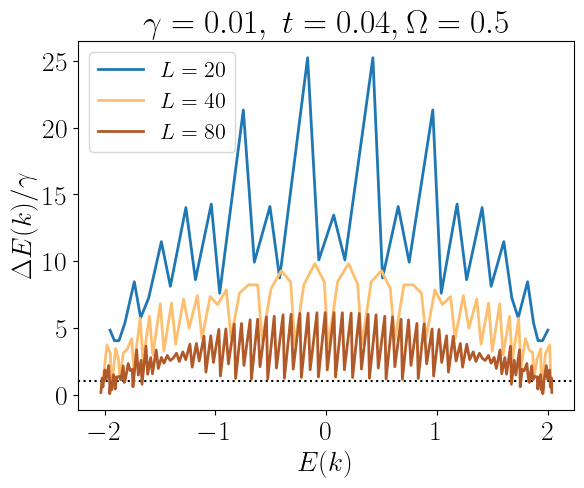

In [37]:
gamma_ = 0.01
t_ = 0.04
Om_ = 0.5

# we now need to extract the energies for each L
fig, ax = plt.subplots(1,1
                      )
cmap = plt.cm.Paired(np.linspace(0.1,1,len(L_qpc_list)))
i = 0
for L_ in L_qpc_list:
    cond = (data_df["t"]==t_) & (data_df["gamma"]==gamma_) & (data_df["L_qpc"]==L_) & (data_df["Omega"]==Om_) 
    k_single_band = np.arange(1,L_+1)*np.pi/(L_+1)
    E = np.sort(data_df[cond]["gamma_energies"].values[0].real)
    DeltaE =  np.diff(E)
    
    plt.plot(E[1:],  DeltaE/gamma_, linewidth=2, c=cmap[i],label=r"$L={}$".format(L_))

    E0m = -2*J[0]*np.cos(k_single_band) - t
    E0p = -2*J[0]*np.cos(k_single_band) + t
    DeltaE0 =  np.diff(E0)

    i+=1

plt.axhline(1, c="black", linestyle="dotted",zorder=0)
plt.xlabel(r"$E(k)$")
plt.ylabel(r"$\Delta E(k)/\gamma$")

plt.title(r"$\gamma = {}, \; t = {}, \Omega = {}$".format(gamma_, t_, Om_))

plt.legend()

plt.savefig(fig_route+"DeltaE_gamma={}_t_={}_Omega={}.pdf".format(gamma_,t_, Om_),bbox_inches='tight')

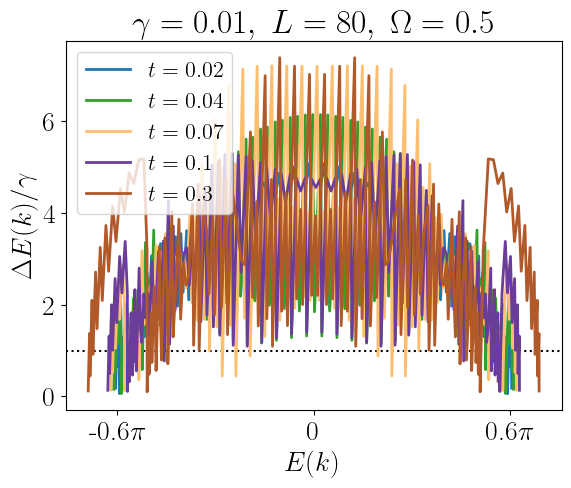

In [38]:
L_ = 80
gamma_ = 0.01
Om_ = 0.5

fig, ax = plt.subplots(1,1)
cmap = plt.cm.Paired(np.linspace(0.1,1,len(t_list)))
i = 0
for t_ in t_list:
    cond = (data_df["t"]==t_) & (data_df["gamma"]==gamma_) & (data_df["L_qpc"]==L_) & (data_df["Omega"]==Om_) 
    k_single_band = np.arange(1,L_+1)*np.pi/(L_+1)
    E = np.sort(data_df[cond]["gamma_energies"].values[0].real)
    DeltaE =  np.diff(E)
    plt.plot(E[1:], DeltaE/gamma_, label=r"$t={}$".format(t_), linewidth=2, c=cmap[i])
    i+=1

plt.axhline(1, c="black", linestyle="dotted",zorder=0)
plt.xlabel(r"$E(k)$")
plt.ylabel(r"$\Delta E(k)/\gamma$")

plt.title(r"$\gamma = {}, \; L = {}, \; \Omega = {}$".format(gamma_, L_, Om_))

plt.legend()

plt.savefig(fig_route+"DeltaE_gamma={}_L_={}_Omega={}.pdf".format(gamma_,L_, Om_),bbox_inches='tight')

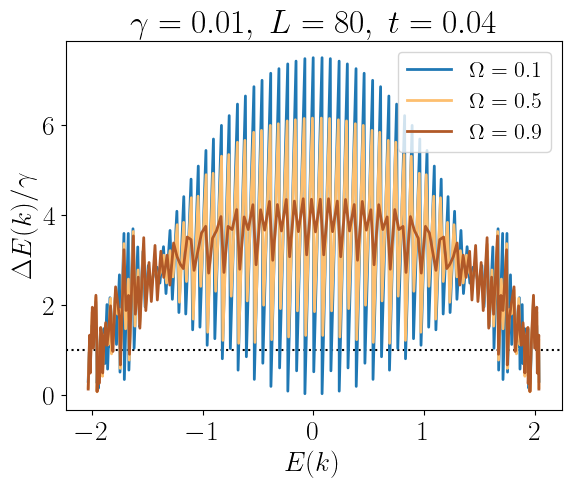

In [39]:
L_ = 80
gamma_ = 0.01
t_ = 0.04
fig, ax = plt.subplots(1,1)
cmap = plt.cm.Paired(np.linspace(0.1,1,len(Omega_list)))
i = 0
for Om_ in Omega_list:
    cond = (data_df["t"]==t_) & (data_df["gamma"]==gamma_) & (data_df["L_qpc"]==L_) & (data_df["Omega"]==Om_) 
    k_single_band = np.arange(1,L_+1)*np.pi/(L_+1)
    E = np.sort(data_df[cond]["gamma_energies"].values[0].real)
    DeltaE =  np.diff(E)
    plt.plot(E[1:], DeltaE/gamma_, label=r"$\Omega={}$".format(Om_), linewidth=2, c=cmap[i])
    i+=1

plt.axhline(1, c="black", linestyle="dotted",zorder=0)
plt.xlabel(r"$E(k)$")
plt.ylabel(r"$\Delta E(k)/\gamma$")

plt.title(r"$\gamma = {}, \; L = {}, \; t={}$".format(gamma_, L_, t_))

plt.legend()

plt.savefig(fig_route+"DeltaE_gamma={}_L_={}_t={}.pdf".format(gamma_,L_, t_),bbox_inches='tight')

In [17]:
# now extracting the maxmium delta E into our df
Emax_list = []
for i in range(0,len(data_df)):
    Emax_list.append(data_df.iloc[i]["gamma_energies"].real.max())

data_df["E_max"] = Emax_list
data_df["E_max_gamma"] = data_df["E_max"]/gamma_ 

cond = (data_df["gamma"]==gamma_) 


<Axes: xlabel='L_qpc', ylabel='t'>

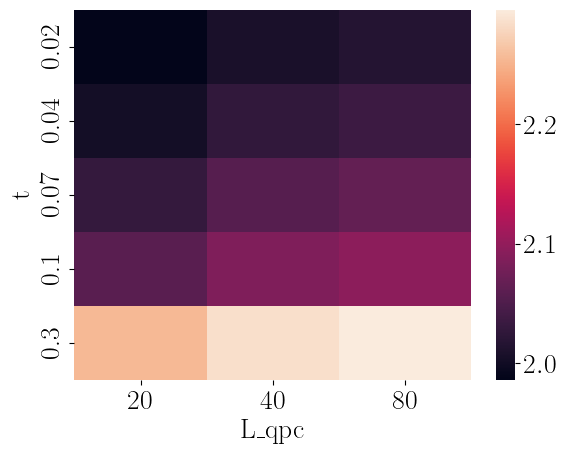

In [18]:
E_df = data_df[cond].pivot_table(index='t', columns='L_qpc', values='E_max', 
                          aggfunc='mean')

sns.heatmap(E_df)